In [ ]:
!pip install pytorch-lightning

In [3]:
!nvidia-smi

Wed Jun  2 14:42:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
% cd /content/gdrive/MyDrive/Research/Fault-Tolerant\ Neural\ Networks/Clevr
!ln -s "/content/gdrive/MyDrive/Research/Fault-Tolerant Neural Networks/Clevr" "/content/clevr"

Mounted at /content/gdrive
/content/gdrive/MyDrive/Research/Fault-Tolerant Neural Networks/Clevr


# Dataset Exploration

In [ ]:
import matplotlib.pyplot as plt
from torchvision import transforms
from tqdm.notebook import tqdm
import sys
sys.path.append('clevr-iep')
from scripts.clevr_dataset import ClevrDataset

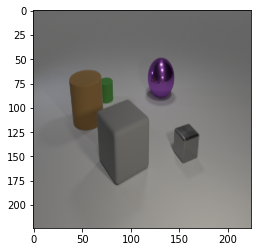

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224))])
dataset = ClevrDataset(root_dir='./data/CLEVR_v1.0/images', image_h5_filename='test_images.h5', transform=transform)
i = 0
plt.imshow(dataset[i].numpy().transpose([1, 2, 0]))

In [ ]:
dataset =  ClevrDataset(root_dir='./data/CLEVR_v1.0/images', image_h5_filename='test_images_2.h5', transform=transform)
dataloader = DataLoader(
            dataset,
            batch_size=32,
            num_workers=4,
            shuffle=False,
            pin_memory=True
)

for data in tqdm(dataloader):
    pass

In [ ]:
!python utils/image2h5.py --image_dir '/content/clevr/data/CLEVR_modified/Overlapping/images' --output_file '/content/clevr/data/CLEVR_modified/Overlapping/test_images.h5'

100% 1000/1000 [08:36<00:00,  1.93it/s]


# Models

In [ ]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
from pytorch_lightning.metrics import Accuracy
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import models
import sys
sys.path.append('clevr-iep')
from scripts.clevr_dataset import ClevrDataset

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    for param in model.parameters():
        param.requires_grad = not feature_extracting

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    return model_ft


In [ ]:
class ClevrClassificationModule(pl.LightningModule):
    def __init__(self, args):
        super().__init__()
        self.hparams = args

        self.criterion = torch.nn.CrossEntropyLoss()
        self.accuracy = Accuracy()
        self.model = initialize_model(args.classifier, args.num_classes, 
                                      args.feature_extract, args.use_pretrained)
        
    def forward(self, images):
        predictions = self.model(images)
        return predictions

    def get_metrics(self, batch):
        images, labels = batch
        predictions = self.forward(images)
        loss = self.criterion(predictions, labels)
        accuracy = self.accuracy(torch.argmax(predictions, dim=1), labels)
        return loss, accuracy

    def training_step(self, batch, batch_nb):
        loss, accuracy = self.get_metrics(batch)
        self.log('loss/train', loss)
        self.log('acc/train', accuracy)
        return loss

    def validation_step(self, batch, batch_nb):
        loss, accuracy = self.get_metrics(batch)
        self.log('loss/val', loss)
        self.log('acc/val', accuracy)

    def test_step(self, batch, batch_nb):
        loss, accuracy = self.get_metrics(batch)
        self.log('acc/test', accuracy)
        return accuracy

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.model.parameters(),
            lr=self.hparams.learning_rate,
            weight_decay=self.hparams.weight_decay,
            momentum=0.9,
            nesterov=True,
        )

        scheduler = CosineAnnealingLR(optimizer, self.hparams.max_epochs)
        return [optimizer], [scheduler]

# Test Training

In [ ]:
import argparse
from pytorch_lightning import Trainer

In [ ]:

parser = argparse.ArgumentParser()
parser.add_argument('--data_dir', type=str, required=True)
parser.add_argument('--image_height', type=int, default=224)
parser.add_argument('--image_width', type=int, default=224)
parser.add_argument('--batch_size', type=int, default=256)
parser.add_argument('--num_workers', type=int, default=1)

# Training args
parser.add_argument('--classifier', type=str, required=True)
parser.add_argument('--num_classes', type=int, default=2)
parser.add_argument('--feature_extract', default=False, action='store_true')
parser.add_argument('--use_pretrained', default=False, action='store_true')
parser.add_argument('--learning_rate', type=float, default=0.01)
parser.add_argument('--weight_decay', type=float, default=0.01)
parser.add_argument('--max_epochs', type=int, default=50)

parser.add_argument('--dev', default=False, action='store_true')
parser.add_argument('--precision', type=int, default=32, choices=[32,64])

arg_str = '--data_dir ./data/CLEVR_v1.0/images --batch_size 256 --classifier resnet --max_epochs 10 --num_workers 4'
args = parser.parse_args(arg_str.split())

In [ ]:
trainer = Trainer(
    fast_dev_run=args.dev,
    logger= None,
    gpus=-1,
    deterministic=False,
    weights_summary=None,
    log_every_n_steps=1,
    max_epochs=args.max_epochs,
    checkpoint_callback=None,
    precision=args.precision,
)

data = ClevrData(args)
model = ClevrClassificationModule(args)
trainer.fit(model, data)
trainer.test(model=model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'acc/test': 1.0}
--------------------------------------------------------------------------------


[{'acc/test': 1.0}]

In [ ]:
trainer.test(model=model, test_dataloaders=data.train_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: Your test_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'acc/test': 0.9994000196456909}
--------------------------------------------------------------------------------


[{'acc/test': 0.9994000196456909}]

In [ ]:
from tqdm.notebook import tqdm
accs = []
for i, batch in enumerate((tqdmdata.train_dataloader())):
    images, labels = batch[0].to('cuda:0'), batch[1].to('cuda:0')
    accs.append(model.test_step((images, labels), i).item())
np.mean(accs)

0.99775390625

In [ ]:
accs = []
for i, batch in enumerate(tqdm(data.val_dataloader())):
    images, labels = batch[0].to('cuda:0'), batch[1].to('cuda:0')
    accs.append(model.test_step((images, labels), i).item())
np.mean(accs)

0.5766096413135529

# Run Clevr *iep*

In [5]:
% cd /content/gdrive/MyDrive/Research/Fault-Tolerant\ Neural\ Networks/Clevr
%cd clevr-iep/

/content/gdrive/MyDrive/Research/Fault-Tolerant Neural Networks/Clevr
/content/gdrive/MyDrive/Research/Fault-Tolerant Neural Networks/Clevr/clevr-iep


In [ ]:
!python3 scripts/run_model_h5.py \
  --program_generator models/CLEVR/program_generator_18k.pt \
  --execution_engine models/CLEVR/execution_engine_18k.pt \
  --root_dir ../data/CLEVR_v1.0/images \
  --image_h5 test_images.h5 \
  --question "Are there blue object?"


Loading program generator from  models/CLEVR/program_generator_18k.pt
Loading execution engine from  models/CLEVR/execution_engine_18k.pt
Loading CNN for feature extraction
100% 469/469 [00:52<00:00,  8.94it/s]
['no', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'no', 'no', 'yes', 'no', 'no', 'no', 'yes', 'no', 'no', 'yes', 'no', 'no', 'no', 'yes', 'no', 'yes', 'no', 'yes', 'no', 'no', 'no', 'yes', 'no', 'yes', 'yes', 'no', 'yes', 'no', 'no', 'no', 'yes', 'yes', 'no', 'yes', 'no', 'yes', 'yes', 'no', 'no', 'yes', 'no', 'yes', 'yes', 'no', 'no', 'no', 'yes', 'no', 'no', 'yes', 'no', 'no', 'yes', 'yes', 'no', 'no', 'yes', 'yes', 'no', 'yes', 'yes', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'no', 'yes', 'no', 'no', 'no', 'no', 'yes', 'no', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'no', 'no', 'yes', 'no', 'no', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'no', 'no', 'no', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'no'

In [ ]:
!python3 scripts/run_model_h5.py \
  --baseline_model models/CLEVR/cnn_lstm_sa.pt \
  --root_dir ../data/CLEVR_v1.0/images \
  --image_h5 test_images.h5 \
  --question "Are there blue object?"


Loading baseline model from  models/CLEVR/cnn_lstm_sa.pt
Loading CNN for feature extraction
100% 469/469 [00:43<00:00, 10.71it/s]
['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'ye

In [27]:
!python3 scripts/run_model.py \
  --program_generator models/CLEVR/program_generator_18k.pt \
  --execution_engine models/CLEVR/execution_engine_18k.pt \
  --image img/CLEVR_val_000013.png \
  --question "How many cubes are there"


Loading program generator from  models/CLEVR/program_generator_18k.pt
Loading execution engine from  models/CLEVR/execution_engine_18k.pt
Loading CNN for feature extraction
Running the model

Question: "How many cubes are there"
Predicted answer:  3

Predicted program:
count
filter_shape[cube]
scene


In [ ]:
python3 scripts/run_models_h5.py --models_dir models/CLEVR --root_dir ../data/CLEVR_modified/Overlapping/ --image_h5 test_images.h5 --questions_file "../questions/overlapping_color/questions.csv" --output_dir ../questions/overlapping_color

In [ ]:
python3 scripts/run_models_h5.py --models_dir models/CLEVR --root_dir ../data/CLEVR_v1.0/images --image_h5 test_images.h5 --question "How many cubes are there" --output_dir ../original_dataset_count_cube

# Check Error Space

In [ ]:
!pip install venn

In [7]:
% cd /content/gdrive/MyDrive/Research/Fault-Tolerant\ Neural\ Networks/Clevr
%cd clevr-iep/

/content/gdrive/MyDrive/Research/Fault-Tolerant Neural Networks/Clevr
/content/gdrive/MyDrive/Research/Fault-Tolerant Neural Networks/Clevr/clevr-iep


In [8]:
from matplotlib_venn import venn2, venn2_circles
from matplotlib import pyplot as plt
import pandas as pd
from venn import venn, draw_venn, generate_colors
import numpy as np
import sys
sys.path.append('clevr-iep')
from scripts.clevr_dataset import ClevrDataset
import os
import random

In [36]:
def plot_images(dataset, indexes, predictions, labels, questions, title):
    # plan the grid for plotting images
    f, axarr = plt.subplots(max(int((len(indexes)) / 2), 2), 2)
    f.set_size_inches(18.5, max(int((len(indexes)) / 2), 2) * 5)
    f.suptitle(title)
    random.shuffle(indexes)
    print(sum([abs(p - l)==1 for p, l in zip(predictions.loc[indexes], labels.loc[indexes])]) / len(predictions.loc[indexes]))
    for i, c in enumerate(indexes):
        x = int(i / 2)
        y = i % 2
        axarr[x, y].imshow(dataset[c])
        axarr[x, y].set_title(f'{questions.loc[c]} \n predicted: {predictions.loc[c]}, actual: {labels.loc[c]}')
    plt.show()

def calculate_expected_error_space(error_probs, total):
    label_map = {}
    n = len(error_probs)
    for i in range(1, 2**n):
        probs = []
        for j, prob in enumerate(reversed(error_probs)):
            probs.append(prob if (i & (1 << j)) > 0 else 1 - prob)
        label = format(i, f'0{n}b')
        label_map[label] = np.round(np.prod(probs) * total)
    return label_map

def calculate_error_space(predictions, labels, dataset, questions, models):
    assert len(models) <= 6, 'maximum number of supported models is 5'

    error_map = {}
    for col in models:
        error_map[f'{col}'] = set(labels[predictions[col] != labels['labels']].index)
    all_failure = set(labels.index)
    for name, errors in error_map.items():
        all_failure = all_failure.intersection(errors)

    error_probs = [(predictions[col] != labels['labels']).sum() / \
                   predictions.shape[0] for col in models]
    label_map = calculate_expected_error_space(error_probs, 
                                               predictions.shape[0])
    
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(20.5, 10.5)
    axs[0].set_title('Expected Error Space')
    draw_venn(dataset_labels = models, ax=axs[0], petal_labels=label_map, 
              hint_hidden=False, colors=generate_colors(n_colors=len(models)),
              figsize=(8, 8), fontsize=14, legend_loc="best")
    axs[1].set_title('Actual Error Space')
    venn(error_map, ax=axs[1])

    plot_images(dataset, list(all_failure)[:10], predictions[models[0]], labels['labels'], questions['questions'],
                'first 10 all failure cases')

In [37]:
folder = '../questions/overlapping_color'
predictions = pd.read_csv(os.path.join(folder, 'results.csv'), index_col=0)
labels = pd.read_csv(os.path.join(folder, 'labels.csv'))
questions = pd.read_csv(os.path.join(folder, 'questions.csv'))
dataset_dir = '../data/CLEVR_modified/Overlapping' #'../data/CLEVR_v1.0/images' 
dataset = ClevrDataset(root_dir=dataset_dir, image_h5_filename='test_images.h5')

1.0


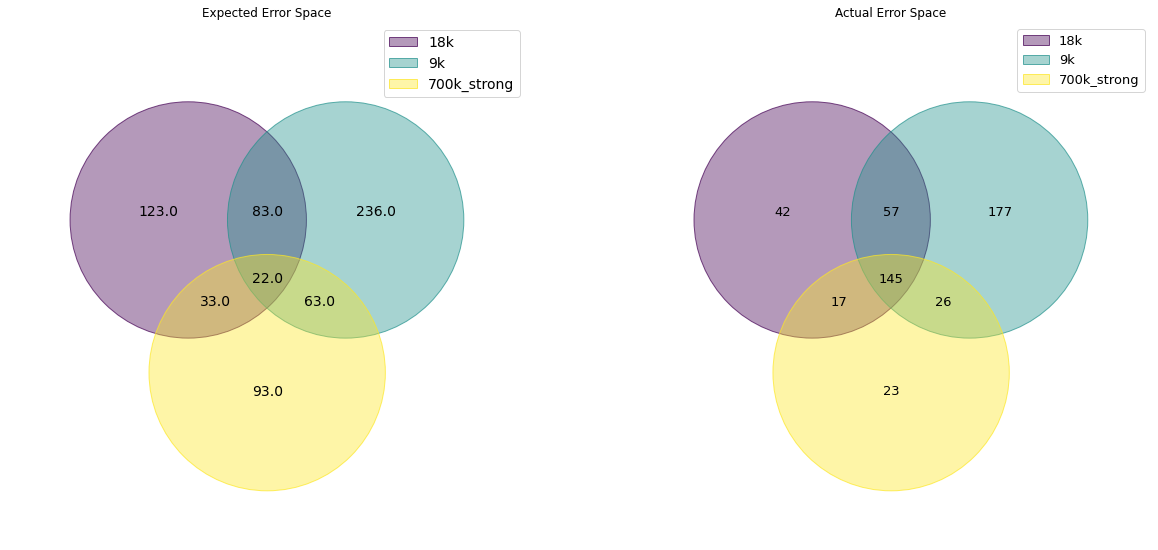

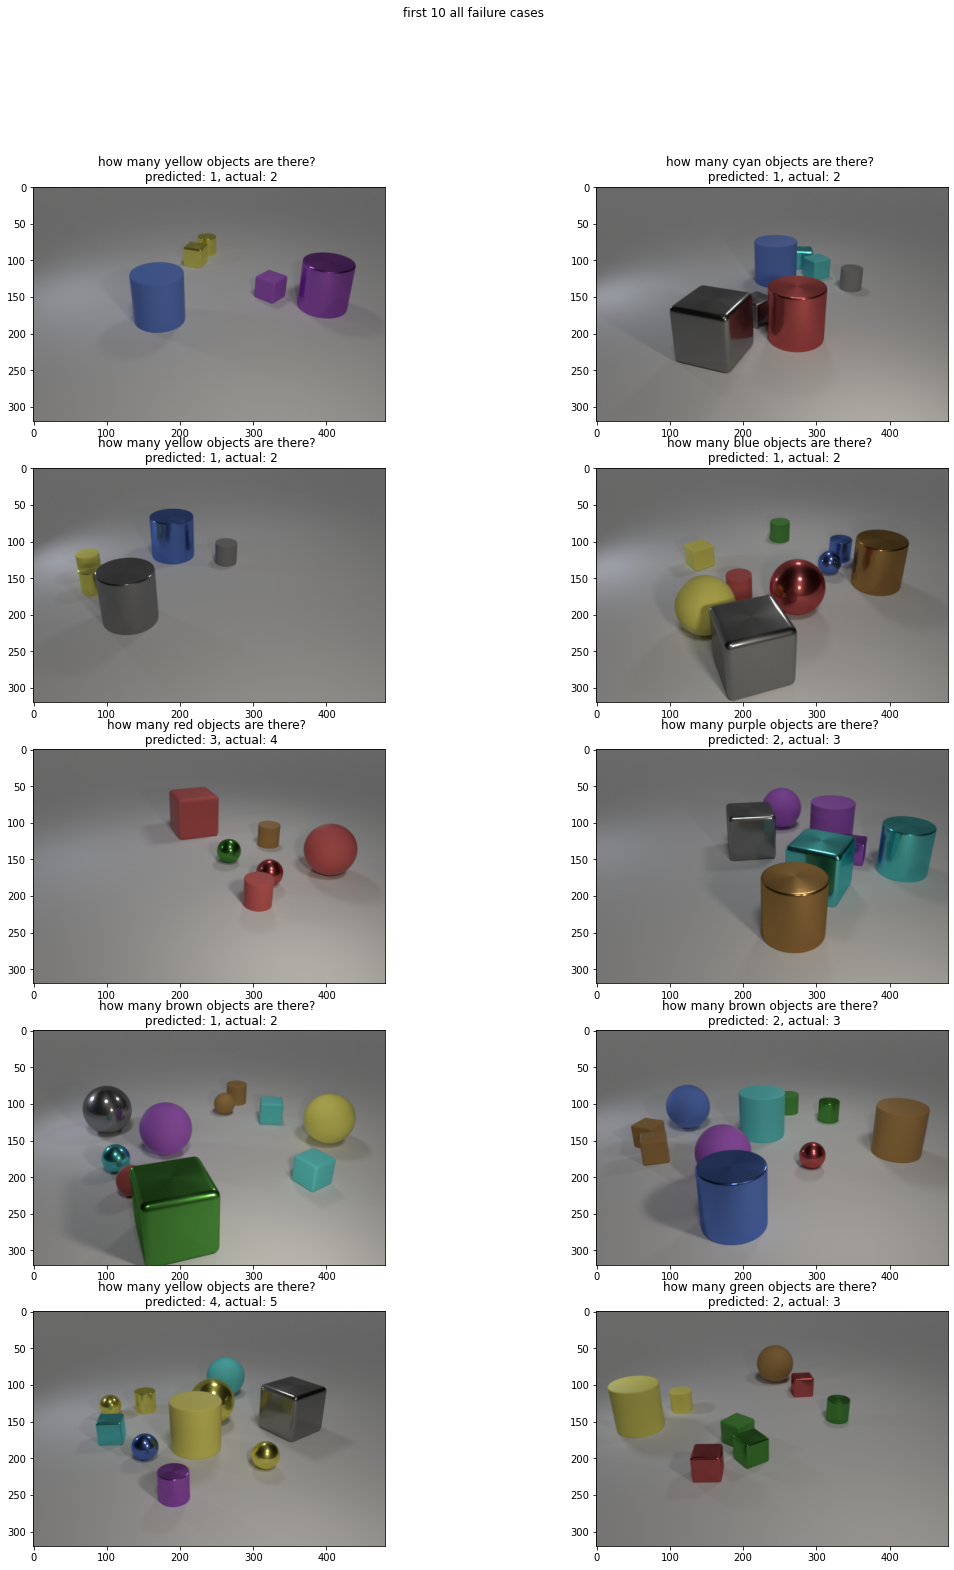

In [39]:
columns = ['18k', '9k', '700k_strong', 'lstm', 'cnn_lstm', 'cnn_lstm_sa','cnn_lstm_sa_mlp']
calculate_error_space(predictions, labels, dataset, questions, ['18k', '9k', '700k_strong'])

In [ ]:
cols = ['cnn_lstm_sa_mlp', '9k', 'lstm']
error_probs = [(predictions[col] != labels['labels']).sum() / predictions.shape[0] for col in cols]
print([e * predictions.shape[0] for e in error_probs])
calculate_expected_error_space(error_probs, predictions.shape[0])

[399.0, 168.0, 6505.0]


{'001': '223.4362',
 '010': '92.6132',
 '011': '2.5308',
 '100': '6261.0490',
 '101': '171.0950',
 '110': '70.9180',
 '111': '1.9380'}

In [ ]:
!python utils/filter_scene.py

100% 15000/15000 [00:00<00:00, 40223.59it/s]


In [31]:
import pandas as pd
pd.DataFrame({'questions': ['Are there red object?'] * 15000}).to_csv('/content/questions.csv')

In [ ]:
question

,0
0,how many blue objects are there?
1,how many brown objects are there?
2,how many cyan objects are there?
3,how many brown objects are there?
4,how many gray objects are there?
...,...
14995,how many gray objects are there?
14996,how many brown objects are there?
14997,how many purple objects are there?
14998,how many red objects are there?
